# Introduction

## Summary

In this notebook, I use 30,000 samples of 2-second .aiff sound files with a sample rate of 2kHz. I proceed to convert the audio to mel spectrogram to generate 255x255 .png images, and then I generate Tfrecords. I then feed the Tfrecords to a CNN with Efficientnet B2 as the backbone of the model architecture to classify if there's a whale call present in the images.

<div style="width:100%;text-align: center;"> <img align=middle src="https://oceanservice.noaa.gov/facts/sound.jpg" width="500" height="300" class ="center"/></div>

## Algorithm main objective 

The main objective of this algorithm is to detect North Atlantic right whale calls from audio recordings in order to prevent collisions with shipping traffic.

## Quick information about Right Whales vocalizations

Right whale are large baleen whales that inhabit the Atlantic ocean. The moans they produce are a type of vocalizations that are characterized by a series of low-frequency sounds that are repeated at regular intervals.

The **frequency range of the right whale moans is typically between 100 and 500 Hz**, with most of the energy cocentrated around **200 Hz**. The moans are usaually produced at a fundamental frequency of around 100 Hz, but contain a series of harmonics and overtones that extend up to 500 Hz. 

## Why is there a need to detect whale sounds?

Detecting whale sounds is important for a few reasons.

Firstly, it helps researchers to understand more about the behavior and communication of these large marine mammals. Whales produce a variety of vocalizations, including songs, whistles, and clicks, which are used for communication and echolocation. By analyzing these sounds, researchers can gain insight into their behavior, migration patterns, and social structure.

Secondly, whale sound detection is crucial for conservation efforts. Many species of whales are endangered or threatened due to factors such as hunting, climate change, and pollution. By tracking their vocalizations, researchers can monitor populations and identify areas where conservation efforts are needed.

**Finally, whale sound detection is also used for maritime safety. Whales can pose a hazard to shipping, and their vocalizations can help ships avoid collisions by alerting them to the presence of whales in the area.**

<div style="width:100%;text-align: center;"> <img align=middle src="https://storage.googleapis.com/kaggle-competitions/kaggle/3353/media/kaggle_whale_detection_3.png" width="500" height="300" class ="center"/></div>

## Data preprocessing

In this notebook, I use TFRecords files which contain 30000 255x255 .png images. For more detailed information on how the audio was transformed into a .png image and then the images were transformed to TFRecords, see the following notebook:

.aiff audio files -> 255x255 .png images transformation.
* [Transforming 2kHz .aiff Whale audio to .png](https://www.kaggle.com/code/diegoasuarezg/transforming-2khz-aiff-whale-audio-to-png)

255x255 png images -> Tfrecords.
* [WDC: 255x255 TFRecord files generation](https://www.kaggle.com/code/diegoasuarezg/wdc-255x255-tfrecord-files-generation)

## References


General information
* [Summary of the Competition](https://www.kaggle.com/competitions/whale-detection-challenge/discussion/4472)
* [NOAA - North Atlantic Right Whale](https://www.fisheries.noaa.gov/species/north-atlantic-right-whale#overview)
* [An overview of North Atlantic right whale acoustic behavior, hearing capabilities, and responses to sound](https://www.sciencedirect.com/science/article/pii/S0025326X21010778)
* [How to Use Kaggle Tensor Processing Units (TPUs)](https://www.kaggle.com/docs/tpu)

Data Card
* [Data Card](https://www.kaggle.com/competitions/whale-detection-challenge/data)

Notebook references
* [SETI-BL: Spatial Info [TF|TPU]](https://www.kaggle.com/code/awsaf49/seti-bl-spatial-info-tf-tpu)
* [Petals to the Metal - Flower Classification on TPU](https://www.kaggle.com/code/ryanholbrook/create-your-first-submission)
* [Inferring Birds with Kaggle Models](https://www.kaggle.com/code/philculliton/inferring-birds-with-kaggle-models)
* [BirdCLEF 2023 | '.ogg' File -> Spectrogram](https://www.kaggle.com/code/haydenismith/birdclef-2023-ogg-file-spectrogram)

# Importing libraries 

Let's start by installing EfficientNet.

In [1]:
# pip installing efficientnet 
!pip install efficientnet --q 
!pip install scikit-learn
!pip install librosa
!pip install plotly
!pip install seaborn

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 68.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 KB 1.8 MB/s eta 0:00:0000:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 KB 6.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 46.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.4 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 834.0 kB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 10.1 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' comm

Now that EfficientNet is installed, we proceed to import the libraries we are going to use throughout the notebook.

In [2]:
# General purpose 
import os
import io
import glob
import zipfile
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable all logging output from TensorFlow
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

# Function used to to render higher resolution images
%config InlineBackend.figure_format = 'retina'

# Reproducibility
import random

# Data manipulation
import numpy as np
import pandas as pd

# Machine learning models and utilities
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import efficientnet.tfkeras as efn
import tensorflow.keras.backend as K
from tensorflow import keras

# Model evaluation 
import sklearn
from sklearn.metrics import (f1_score,
                             precision_score,
                             recall_score,
                             confusion_matrix
                            )
from tensorflow.keras.callbacks import EarlyStopping


# Data visualization
import matplotlib.pyplot as plt
from plotly.offline import (init_notebook_mode,
                            iplot,
                            plot
                           )
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import seaborn as sns

# Audio processing libraries
import librosa 
import soundfile as sf
from IPython.display import Audio

# ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# Notebook configuration 

In this section, we define some constants that are going to be used quite a few times.

In [4]:
# Use TPU accelerator
DEVICE = "TPU" #or "GPU"

# Batch size 
BATCH_SIZE = 16 * 8 #Batch size 16 * 8 Replicas

# Seed value for reproducibility
SEED = 29

# Images size
IMG_SIZES = [[255, 255]]

# Total number of epochs
EPOCHS = [6]

# Augment and transform images 
AUGMENT   = True
TRANSFORM = True

# Transormations parameters
ROT_    = 0.0
SHR_    = 2.0
HZOOM_  = 8.0
WZOOM_  = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

To ensure reproducibility of our results, we will seed our notebook with a fixed random seed.

In [6]:
# Seeding all the notebook for reproducibility purposes
def seed_it(SEED):
    
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)

    print('Notebook has been seeded successfully')

In [8]:
seed_it(SEED)

Notebook has been seeded successfully


# TPU connection

TPU's are hardware accelerators specialized in deep learning tasks. They are equipped with 128GB of high-speed memory allowing larger batches, larger models and also larger training inputs.

For more information about the kaggle's TPU please refer to the document in the following link:

[Tensor Processing Units (TPUs)](https://www.kaggle.com/docs/tpu)

<div style="width:100%;text-align: center;"> <img align=middle src="https://storage.googleapis.com/kaggle-media/tpu/tpuv3angle.jpg" width="400" height="400" class ="center"/></div>

Following codes automatically detects hardware(tpu or gpu or cpu):

In [9]:
# Connect to TPU V3-8 accelator 
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        # detect and init the TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            # instantiate a distribution strategy
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

# If Can't detect TPU accelerator connect to GPU else use CPU    
if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    # instantiate a distribution strategy
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  0
REPLICAS: 1


# Exploratory analysis 

Before building our whale sound classification model, let's explore a random sample audio file to get an idea of what a whale call should sound like. For this purpose, we will use one of the samples available in the 'small_data_sample_revised.zip' file.

In [10]:
# Open ZIP file using the zipfile module and print a list of the file names inside
example = zipfile.ZipFile('/kaggle/input/whale-detection-challenge/small_data_sample_revised.zip')
print (example.namelist())

['small_data_sample/', 'small_data_sample/no_right_whale/', 'small_data_sample/no_right_whale/train1.aiff', '__MACOSX/', '__MACOSX/small_data_sample/', '__MACOSX/small_data_sample/no_right_whale/', '__MACOSX/small_data_sample/no_right_whale/._train1.aiff', 'small_data_sample/no_right_whale/train2.aiff', '__MACOSX/small_data_sample/no_right_whale/._train2.aiff', 'small_data_sample/no_right_whale/train3.aiff', '__MACOSX/small_data_sample/no_right_whale/._train3.aiff', 'small_data_sample/no_right_whale/train4.aiff', '__MACOSX/small_data_sample/no_right_whale/._train4.aiff', 'small_data_sample/no_right_whale/train5.aiff', '__MACOSX/small_data_sample/no_right_whale/._train5.aiff', 'small_data_sample/right_whale/', 'small_data_sample/right_whale/train12.aiff', '__MACOSX/small_data_sample/right_whale/', '__MACOSX/small_data_sample/right_whale/._train12.aiff', 'small_data_sample/right_whale/train28.aiff', '__MACOSX/small_data_sample/right_whale/._train28.aiff', 'small_data_sample/right_whale/t

Now that we've seen what the zip file contains, let's import the example 'train6.aiff', which corresponds to a right whale call (class 1).

In [11]:
# Read audio file "train6.aiff" from a ZIP opened above using the zipfile and librosa modules
with zipfile.ZipFile('/kaggle/input/whale-detection-challenge/small_data_sample_revised.zip','r') as myzip:
    audio_file=myzip.read("small_data_sample/right_whale/train6.aiff")
import librosa
audio, sr=librosa.load(io.BytesIO(audio_file))

We can use the IPython.display module to play the audio sample and listen to the whale call.

In [12]:
# Displaying 2-second right whale call audio using IPython.display module
Audio(data=audio, rate=sr)

Let's visually inspect this audio sample by computing its waveform over time.

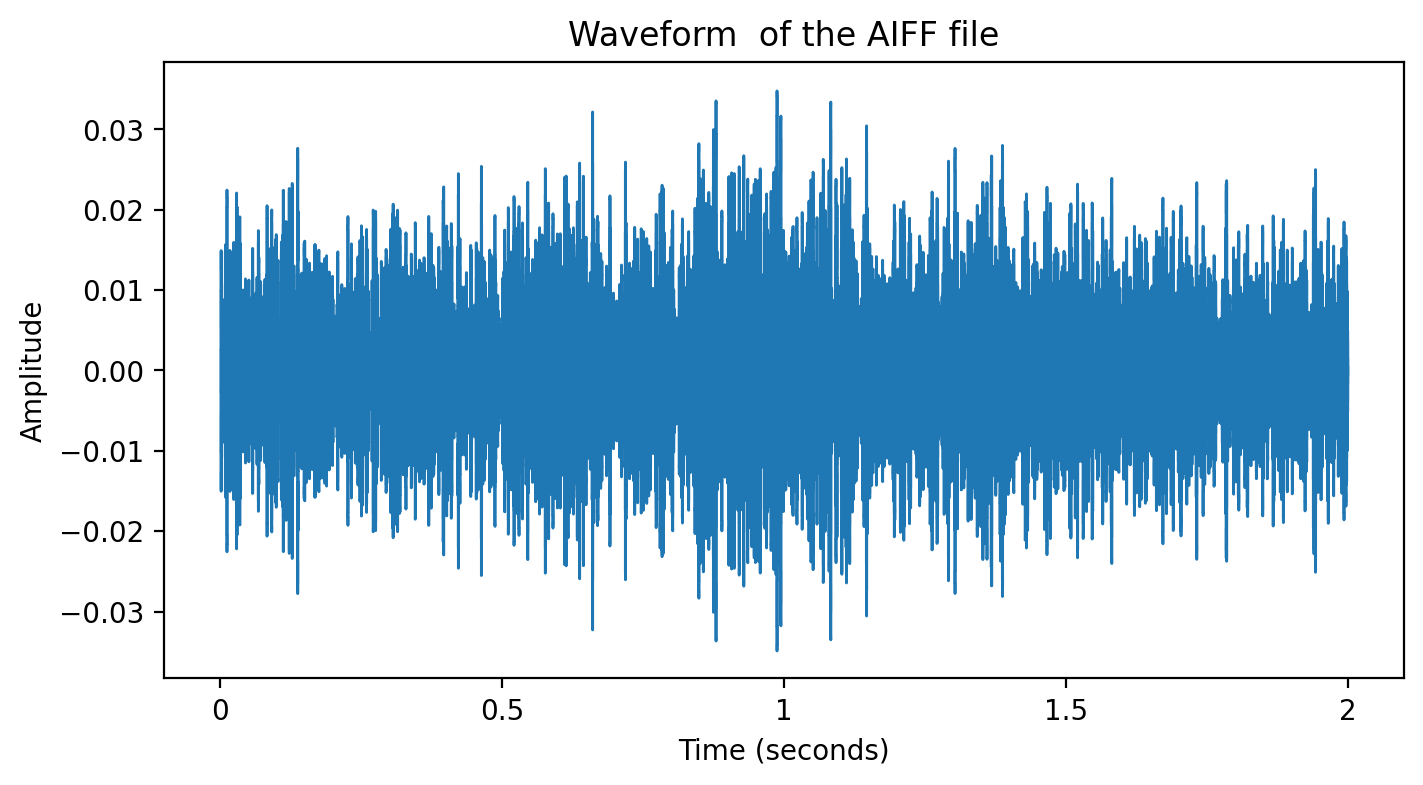

In [13]:
# Displaying audio waveform using librosa module
# X-axis is time while y-axis is amplitude
plt.figure(figsize=(8,4))
librosa.display.waveshow(audio,sr=sr)
plt.title('Waveform  of the AIFF file')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

Now we proceed to calculate the mel spectrogram of the audio sample 'train6.aiff'.


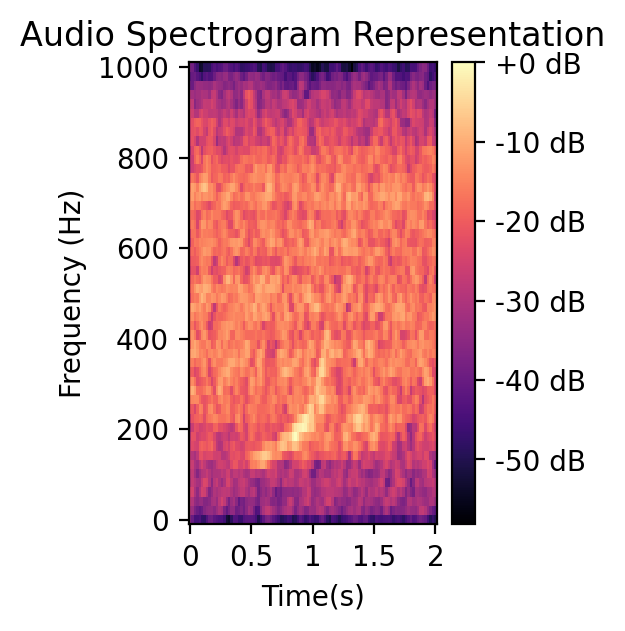

In [14]:
# Computing mel spectogram of the loaded audio file
samples, sr = sf.read(io.BytesIO(audio_file))

n_fft = 200 #frame duration = n_fft /sr. If we want to get a 0.1-second frame duration at 2kHz our value must be 200.
hop_length = 40 #0.2*n_fft 
n_mels=50 # Ajusted this value till the image had a good resolution
S = librosa.feature.melspectrogram(y=samples,
                                   sr=sr,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   n_mels=n_mels,
                                   )
S_db = librosa.power_to_db(S, ref=np.max)

# Plotting spectrogram. X-axis is time y-axis is frequency 
#and color heatmap represent dB (decibels) 
fig, ax = plt.subplots(figsize=(2,3))
librosa.display.specshow(S_db,
                         x_axis='time',
                         y_axis='linear',
                         sr=sr,
                         hop_length=hop_length,
                         )
plt.title("Audio Spectrogram Representation")
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time(s)")
plt.ylabel("Frequency (Hz)")
plt.show()

As we said in the section 'Quick Information about Right Whales Vocalizations', whale vocalizations mainly occur between 100 to 500Hz. So, let's limit our mel spectrogram to show us a max frequency of 500 Hz. Additionally, let's remove the axis information, and finally, we have our image ready to be fed to our CNN model.

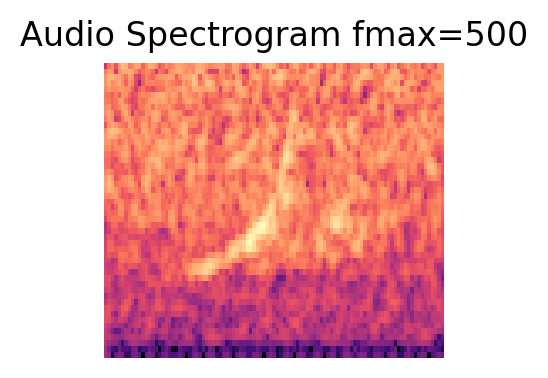

In [15]:
samples, sr = sf.read(io.BytesIO(audio_file))

n_fft = 200
hop_length = 40
n_mels=50
S = librosa.feature.melspectrogram(y=samples,
                                   sr=sr,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   n_mels=n_mels,
                                   fmax=500 # Limiting the spectrogram to only 500 Hz frequency
                                   )
S_db = librosa.power_to_db(S, ref=np.max)
fig, ax = plt.subplots(figsize=(2,2)) 
librosa.display.specshow(S_db,
                         x_axis='time',
                         y_axis='linear',
                         sr=sr,
                         hop_length=hop_length,
                         )
plt.title("Audio Spectrogram fmax=500")
plt.axis('off') # Removing all axis 
plt.tight_layout()
plt.show()

This seems to closely match an [example](https://www.kaggle.com/competitions/whale-detection-challenge/data) of a clip containing right whale calls shared by the competition organizers. We know we are on the right track, so let's keep going

![Example](https://storage.googleapis.com/kaggle-competitions/kaggle/3353/media/whale_detection_challenge-cwc-es.png)

Now let's inspect our training labels and see how balanced the dataset is. 

In [17]:
# Search for all the files in the specified directory 
zipfiles = glob.glob('/kaggle/input/whale-detection-challenge/whale_data.zip')

# Extracting train.csv (labels) from the zip file
for zippath in zipfiles:
    with zipfile.ZipFile(zippath, 'r') as zip_file:
        zip_file.extract('data/train.csv')
        labels = pd.read_csv(zip_file.open('data/train.csv'))

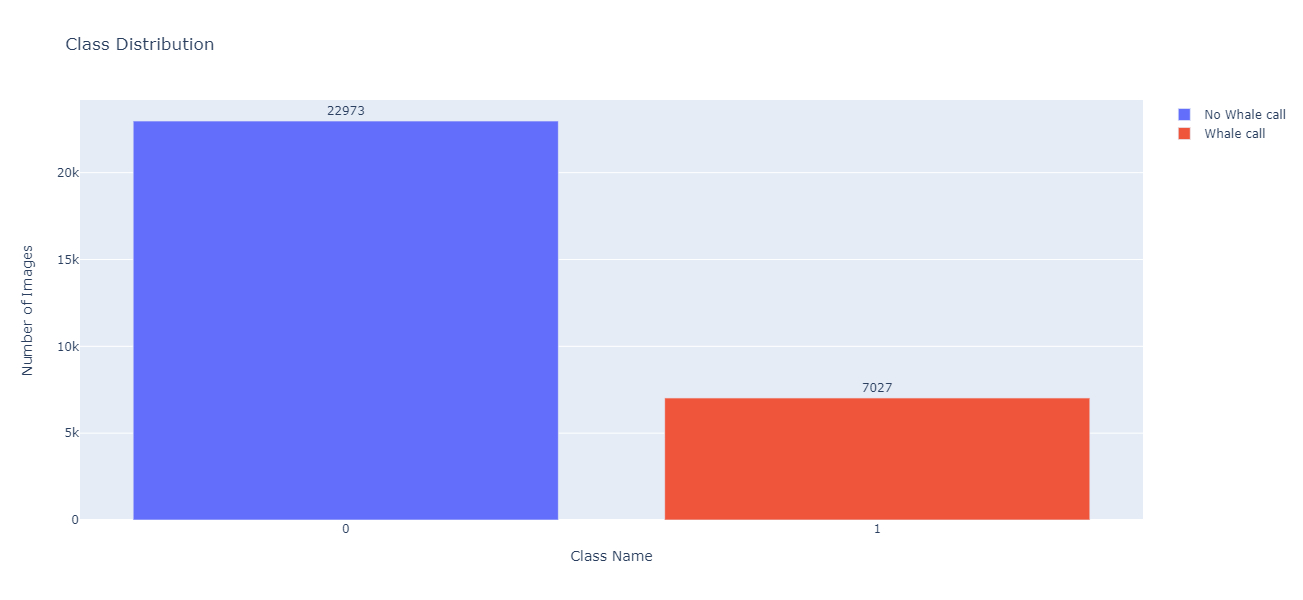

In [18]:
# Plot bargraph and with value counts for each class
fig = go.Figure(data=[
    go.Bar(name='No Whale call', 
           y=labels[labels['label']==0]['label'].value_counts(),
           x=['0'],
           text = labels[labels['label']==0]['label'].value_counts(),
           orientation='v',
           textposition='outside',),
    
    go.Bar(name='Whale call', 
           y=labels[labels['label']==1]['label'].value_counts(),
           x=['1'],
           text = labels[labels['label']==1]['label'].value_counts(),
           orientation='v',
           textposition='outside',),
])

fig.update_layout(
                  width=800,
                  height=600,
                  title=f'Class Distribution',
                  yaxis_title='Number of Images',
                  xaxis_title='Class Name',)
iplot(fig)

We can observe that our dataset is very unbalanced. It seems that the 'No whale call' class (class 0) is more predominant. Hopefully, we can tackle this problem by using focal loss as our loss function.

# Image augmentation

To make our model more robust, we perform some slight alterations to the images. 

In the subsequent code cell, we first define a function to obtain various transformation matrices. The second function applies the transformation matrix with random parameters to one of the training images.

In [19]:
# Augment image: rotation, shear, zoom and shift 

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=IMG_SIZES[0]):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
        
    if DIM[0]!=DIM[1]:
        pad = (DIM[0]-DIM[1])//2
        image = tf.pad(image, [[0, 0], [pad, pad+1],[0, 0]])
        
    NEW_DIM = DIM[0]
    
    XDIM = NEW_DIM%2
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(NEW_DIM//2, -NEW_DIM//2,-1), NEW_DIM)
    y   = tf.tile(tf.range(-NEW_DIM//2, NEW_DIM//2), [NEW_DIM])
    z   = tf.ones([NEW_DIM*NEW_DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -NEW_DIM//2+XDIM+1, NEW_DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([NEW_DIM//2-idx2[0,], NEW_DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
    
    if DIM[0]!=DIM[1]:
        image = tf.reshape(d,[NEW_DIM, NEW_DIM,3])
        image = image[:, pad:DIM[1]+pad,:]
    image = tf.reshape(image, [*DIM, 3])
        
    return image

# Data Pipeline

Since we are working with data stored in the tfrecords format, it is necessary to build a data pipeline to convert the data into a format that can be used by the ConvNet model.

Let's start by obtaining the Google Storage dataset path.

In [20]:
# Create Google Cloud Storage(GCS) path of the 'Whale-detection-challenge' dataset
GCS_PATH = [None]
for i,k in enumerate(IMG_SIZES):
    GCS_PATH[i] = KaggleDatasets().get_gcs_path('whale-detection-challenge-%ix%i-tfrec-dataset'%(k[0],k[1]))

print(GCS_PATH)

['gs://kds-d1beaa85055f8f1d42c5bbe69e8156f3b1ad0f9c7974a351b3f84bd9']


In [21]:
# Get the total number of files inside the dataset
files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
num_train_files = len(files)
print('train_files:',num_train_files)

train_files: 10


In [23]:
# Print all the Tfrecord dataset file names
files

array(['gs://kds-d1beaa85055f8f1d42c5bbe69e8156f3b1ad0f9c7974a351b3f84bd9/train00-3000.tfrec',
       'gs://kds-d1beaa85055f8f1d42c5bbe69e8156f3b1ad0f9c7974a351b3f84bd9/train01-3000.tfrec',
       'gs://kds-d1beaa85055f8f1d42c5bbe69e8156f3b1ad0f9c7974a351b3f84bd9/train02-3000.tfrec',
       'gs://kds-d1beaa85055f8f1d42c5bbe69e8156f3b1ad0f9c7974a351b3f84bd9/train03-3000.tfrec',
       'gs://kds-d1beaa85055f8f1d42c5bbe69e8156f3b1ad0f9c7974a351b3f84bd9/train04-3000.tfrec',
       'gs://kds-d1beaa85055f8f1d42c5bbe69e8156f3b1ad0f9c7974a351b3f84bd9/train05-3000.tfrec',
       'gs://kds-d1beaa85055f8f1d42c5bbe69e8156f3b1ad0f9c7974a351b3f84bd9/train06-3000.tfrec',
       'gs://kds-d1beaa85055f8f1d42c5bbe69e8156f3b1ad0f9c7974a351b3f84bd9/train07-3000.tfrec',
       'gs://kds-d1beaa85055f8f1d42c5bbe69e8156f3b1ad0f9c7974a351b3f84bd9/train08-3000.tfrec',
       'gs://kds-d1beaa85055f8f1d42c5bbe69e8156f3b1ad0f9c7974a351b3f84bd9/train09-3000.tfrec'],
      dtype='<U84')

Now, we define a function to read and decode the images in the dataset. Next, we read the dataset labels and finally load the dataset.

In [24]:
# Load TFRecord format dataset

CLASSES = ['No whale call','Whale call']  

# Decode png images 
def decode_image(image_data):
    image = tf.image.decode_png(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*[255, 255], 3]) # explicit size needed for TPU
    return image

# Read labels
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        'image': tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

# Load dataset
def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding m,data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

We then build a function that applies augmentations to the training set. Additionally, we build functions that allow us to obtain the training and validation datasets.

In [25]:
# Images random augmentations 
def data_augment(img, label, dim=IMG_SIZES[0]):
    img = transform(img,DIM=dim) if TRANSFORM else img     
    return img, label   

# Get training dataset
def get_training_dataset():
    dataset = train_dataset.map(data_augment,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(1024*2, seed=SEED)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

# Get validation dataset 
def get_validation_dataset(ordered=False):
    dataset = val_dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Count number of items in the dataset 
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

Let's count the total number of files inside the TFRecord format.

In [27]:
# Count total number of images in the dataset 
NUM_IMAGES = count_data_items(files)

print('Dataset: {} total images'.format(NUM_IMAGES))

Dataset: 30000 total images


Since we don't have a separate test or validation dataset, we split the training set to obtain a validation set that can be used to evaluate our model later.

In [29]:
# Train - Validation split 
train_size = int(0.8 * NUM_IMAGES)
val_size = int(0.20 * NUM_IMAGES)

full_dataset=load_dataset(files, labeled=True)
full_dataset = full_dataset.shuffle(1024*2, seed=SEED)
train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)

Finally, we are ready to obtain our training and validation sets.

In [30]:
# Get training dataset 
ds_train = get_training_dataset()

# Get validation dataset
ds_val=get_validation_dataset()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [31]:
# Training and Validation set details 
print("Training:", ds_train,'\n')
print("Validation:", ds_val,'\n')

Training: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> 

Validation: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> 



Each batch contains 128 images with 255x255x3(rgb) dimensions.

Let's now define our plotting functions.

In [32]:
#Plotting functions 

# Transform images and labels batch to numpy array 
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

# Label title / will compare if label is correct or not 
def title_from_label_and_label(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

# Display one image 
def display_one_image(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

# Display batch of images 
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_label(predictions[i][0], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_image(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [34]:
# Get a 20 image form one of the training batch 
ds_iter = iter(ds_train.unbatch().batch(20))

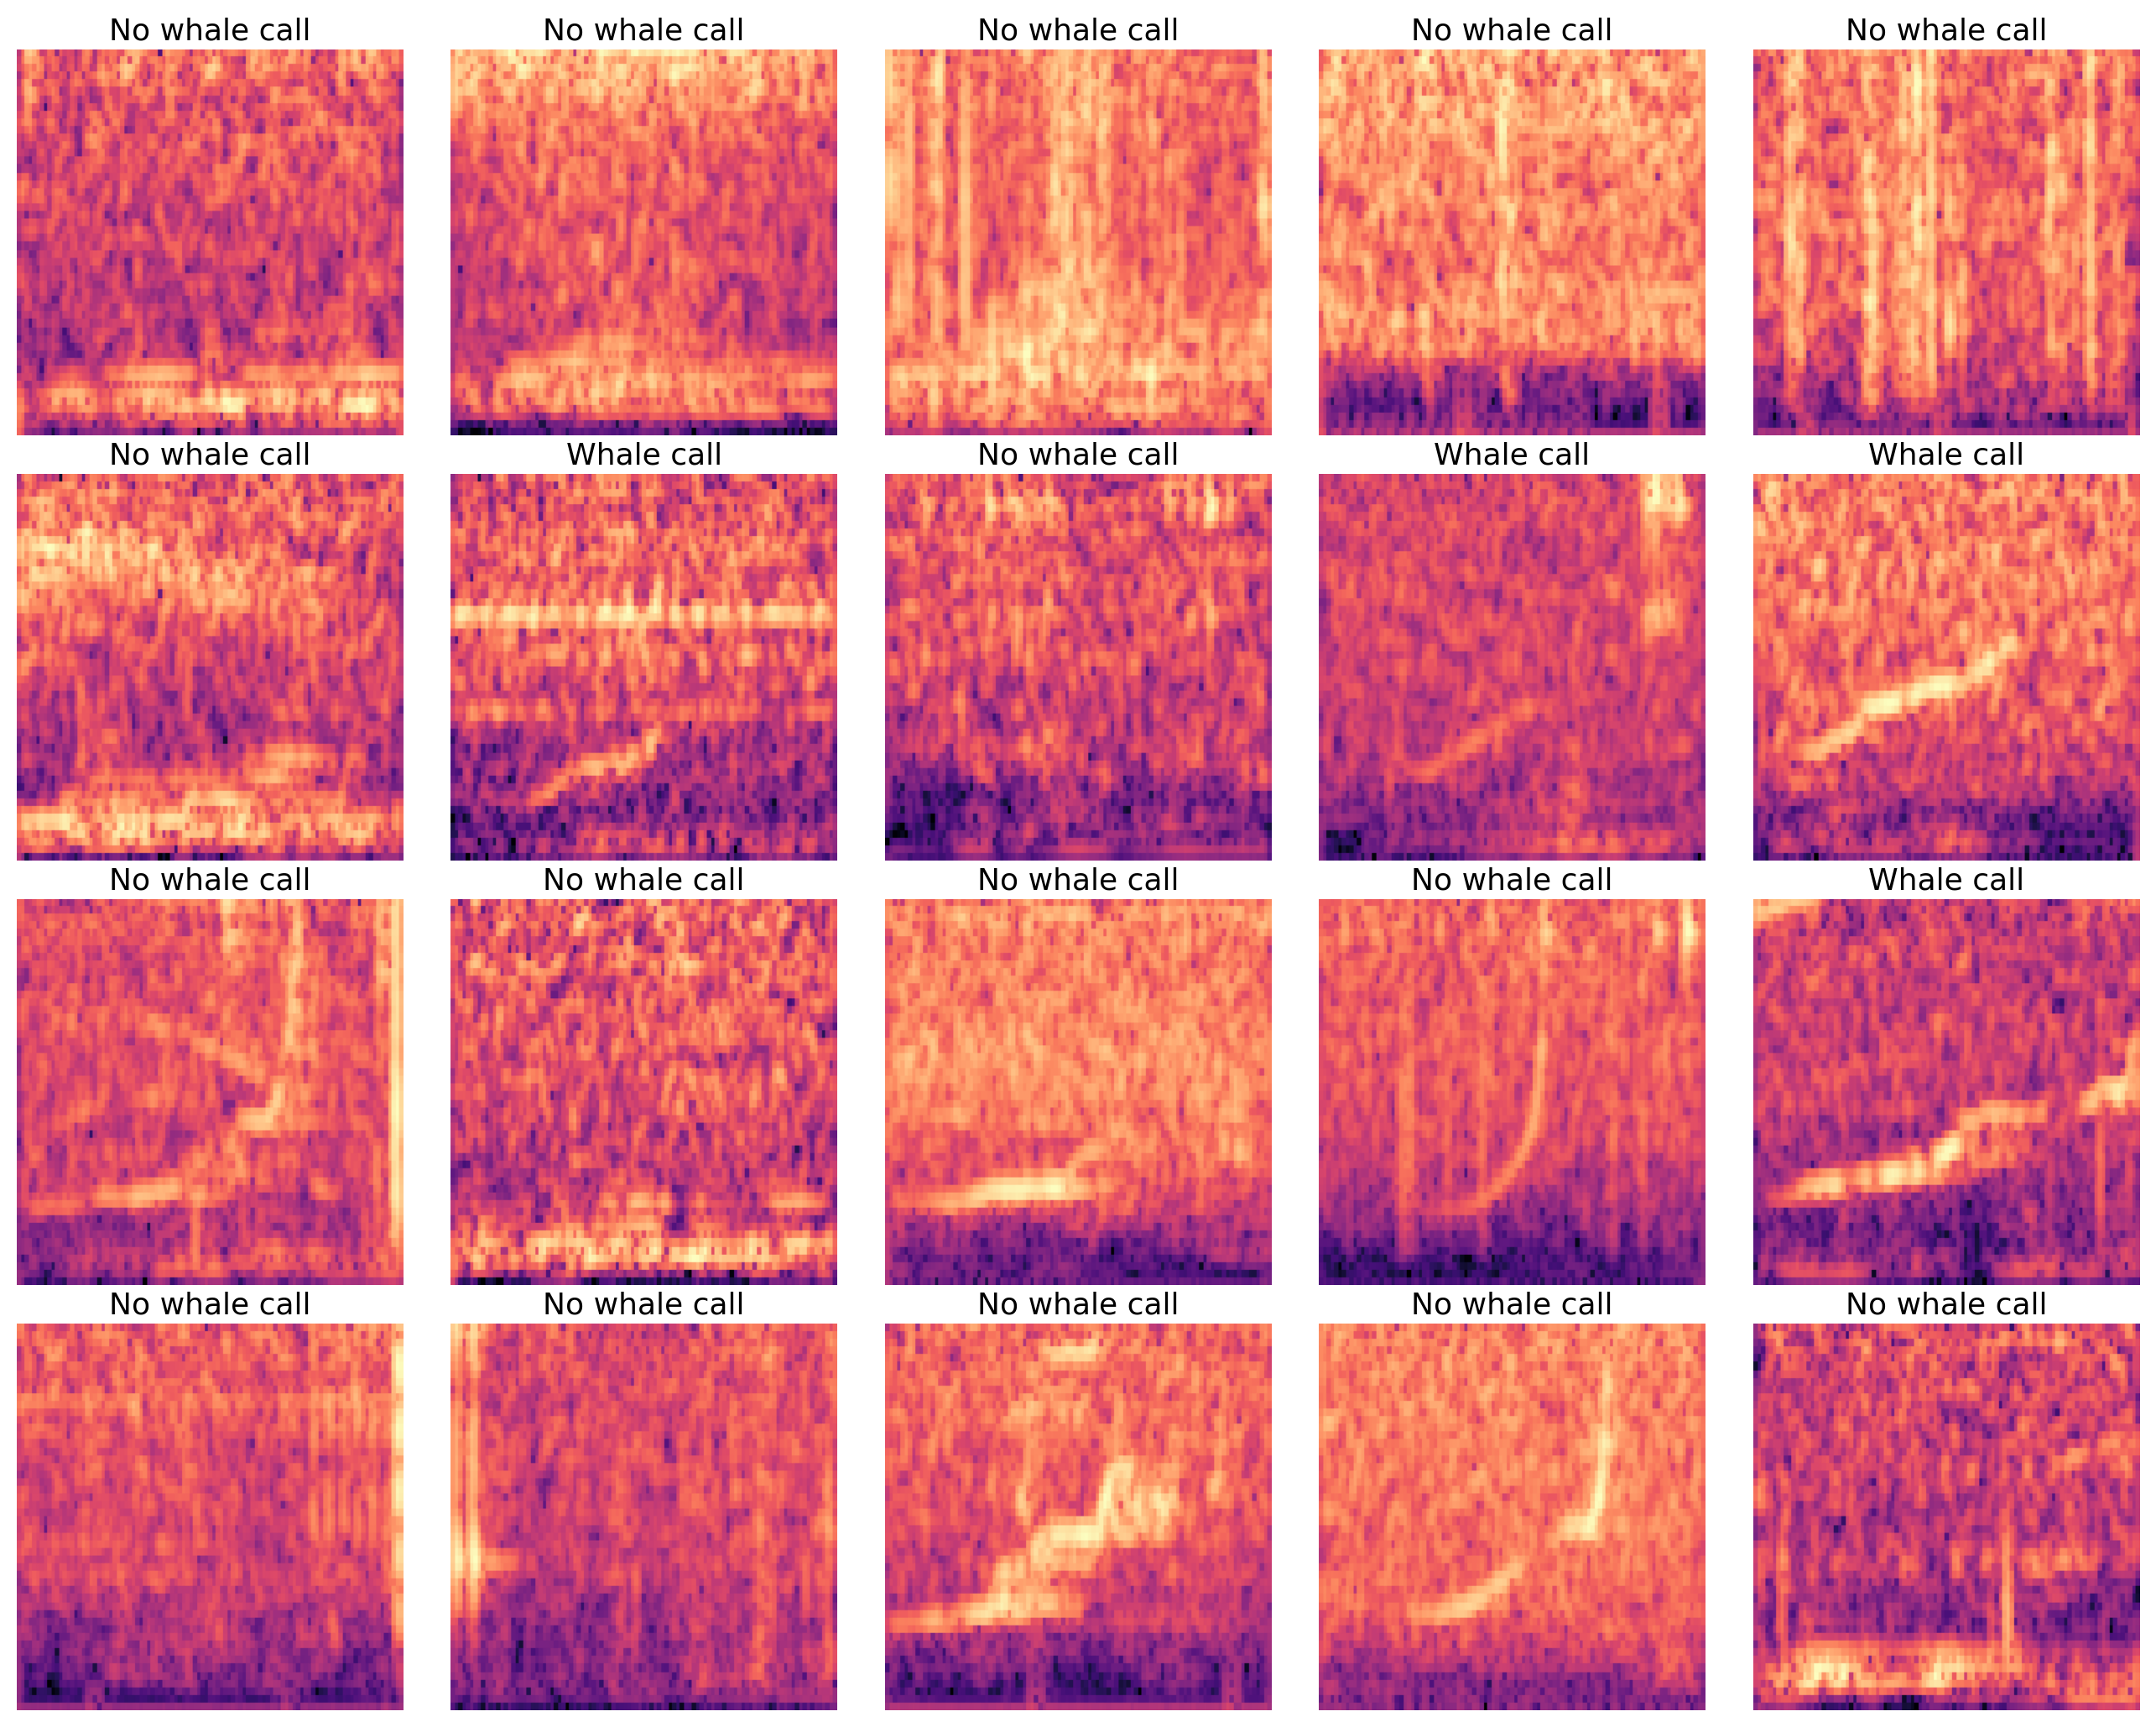

In [36]:
# Display sample images 
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

Okay, now that we have our data ready to be fed to the model, it's time to build the model.

# ConvNet building

Let's first build a function to display our training curve and confusion matrix so we can evaluate our model later.

In [37]:
# Display training curves  
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Display confusion matrix    
def display_confusion_matrix(cmat):
    plt.figure(figsize=(4,4))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 10})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 10})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""

Next, we will define our binary focal loss function. I would like to thank [The Devastator](https://www.kaggle.com/thedevastator) for providing this function.

But first, why use focal loss instead of binary cross-entropy in the first place?

Binary cross-entropy is a commonly used loss function for binary classification tasks, but it assumes a balanced class distribution. In an unbalanced dataset, where one class has significantly more samples than the other(s), binary cross-entropy can lead to a model that is biased towards the majority class.

Focal loss, on the other hand, was introduced as a way to address the problem of class imbalance in object detection tasks. It down-weights the contribution of well-classified examples, putting more emphasis on examples that are hard to classify, which are often the minority class examples. Focal loss helps to reduce the influence of the majority class during training and focuses the model more on the minority class. As a result, it can improve the overall accuracy, especially for the minority class.

Therefore, it is recommended to use binary focal loss instead of binary cross-entropy as a loss function when dealing with an unbalanced dataset.

In [38]:
# Defining binary focal loss function
def binary_focal_loss(gamma = 2., alpha = .25):
    def tf_binary_focal_loss_fixed(y_true, y_pred):
         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
         epsilon = K.epsilon()
         pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
         pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
         return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return tf_binary_focal_loss_fixed

We now define a learning rate schedule. So, why use it? 

A learning rate schedule helps the model to learn more efficiently by starting with larger updates to the model parameters and gradually reducing the step size as training progresses. This can lead to better model performance and more accurate predictions.

In [39]:
# Learning Rate Schedule for Fine Tuning 
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.85):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

We also define our Early stopping criteria with a minimum delta of 0.001.

In [41]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, restore_best_weights=True)

We will now build our model using EfficientNet B2 as the backbone, which has around 9.2 million parameters and is deeper and wider than B1, making it well-suited for our dataset. Although we could have used other alternatives like ResNet, VGG, Inception, or DenseNet, for the sake of simplicity, we will stick with only EfficientNet.

It is worth mentioning that I manually tuned the hyperparameters of the model. I found that using a dense layer with 40 neurons helped achieve very good results. Additionally, I adjusted some parameters in the learning rate schedule to fine-tune the model.



In [42]:
# Distributing computation across multiple TPU cores.
with strategy.scope():
    # Use EfficientNet B2 as backbone base classification model 
    pretrained_model = efn.EfficientNetB2(
        weights='imagenet',
        include_top=False ,
        input_shape=[*[255,255], 3]
    )
    
    # Don't train pretrained model weights 
    pretrained_model.trainable = False
    
    # Model arquitecture
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),# use GAP to get pooling result form conv outputs
        tf.keras.layers.Dense(40, activation= 'relu'), # Dense layer with activation function for non-linearity
        tf.keras.layers.Dense(1, activation='sigmoid') # Output layer with 1 neuron and sigmoid activation function
    ])

31936256/31936256 [==============================] - 0s 0us/step


We will now compile the model and assign binary focal loss as the loss function.

In [43]:
# Compile model - Loss= Binary focal loss
model.compile(
    optimizer='adam',
    loss=binary_focal_loss(),
    metrics=['binary_accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b2 (Functional  (None, 8, 8, 1408)       7768562   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 40)                56360     
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 7,824,963
Trainable params: 56,401
Non-trainable params: 7,768,562
_________________________________________________________________


We are ready to fit our model!

In [44]:
# Training epochs definition 
steps_per_epoch = train_size // BATCH_SIZE

# Fitting the model 
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS[0],
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback,early_stopping]
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/6
187/187 [==============================] - 817s 4s/step - loss: 4.4326 - binary_accuracy: 0.8039 - val_loss: 3.4809 - val_binary_accuracy: 0.8418 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/6
187/187 [==============================] - 800s 4s/step - loss: 3.5560 - binary_accuracy: 0.8542 - val_loss: 3.1602 - val_binary_accuracy: 0.8805 - lr: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/6
187/187 [==============================] - 804s 4s/step - loss: 3.3757 - binary_accuracy: 0.8637 - val_loss: 3.1624 - val_binary_accuracy: 0.8562 - lr: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/6
187/187 [==============================] - 806s 4s/step - loss: 3.2381 - binary_accuracy: 0.8712 - val_loss: 2.9877 - val_binary_accuracy: 0.8822 - lr: 2.

# ConvNet evaluation

Now, we will evaluate the performance of our model by plotting a loss versus validation loss curve and an accuracy versus validation curve.

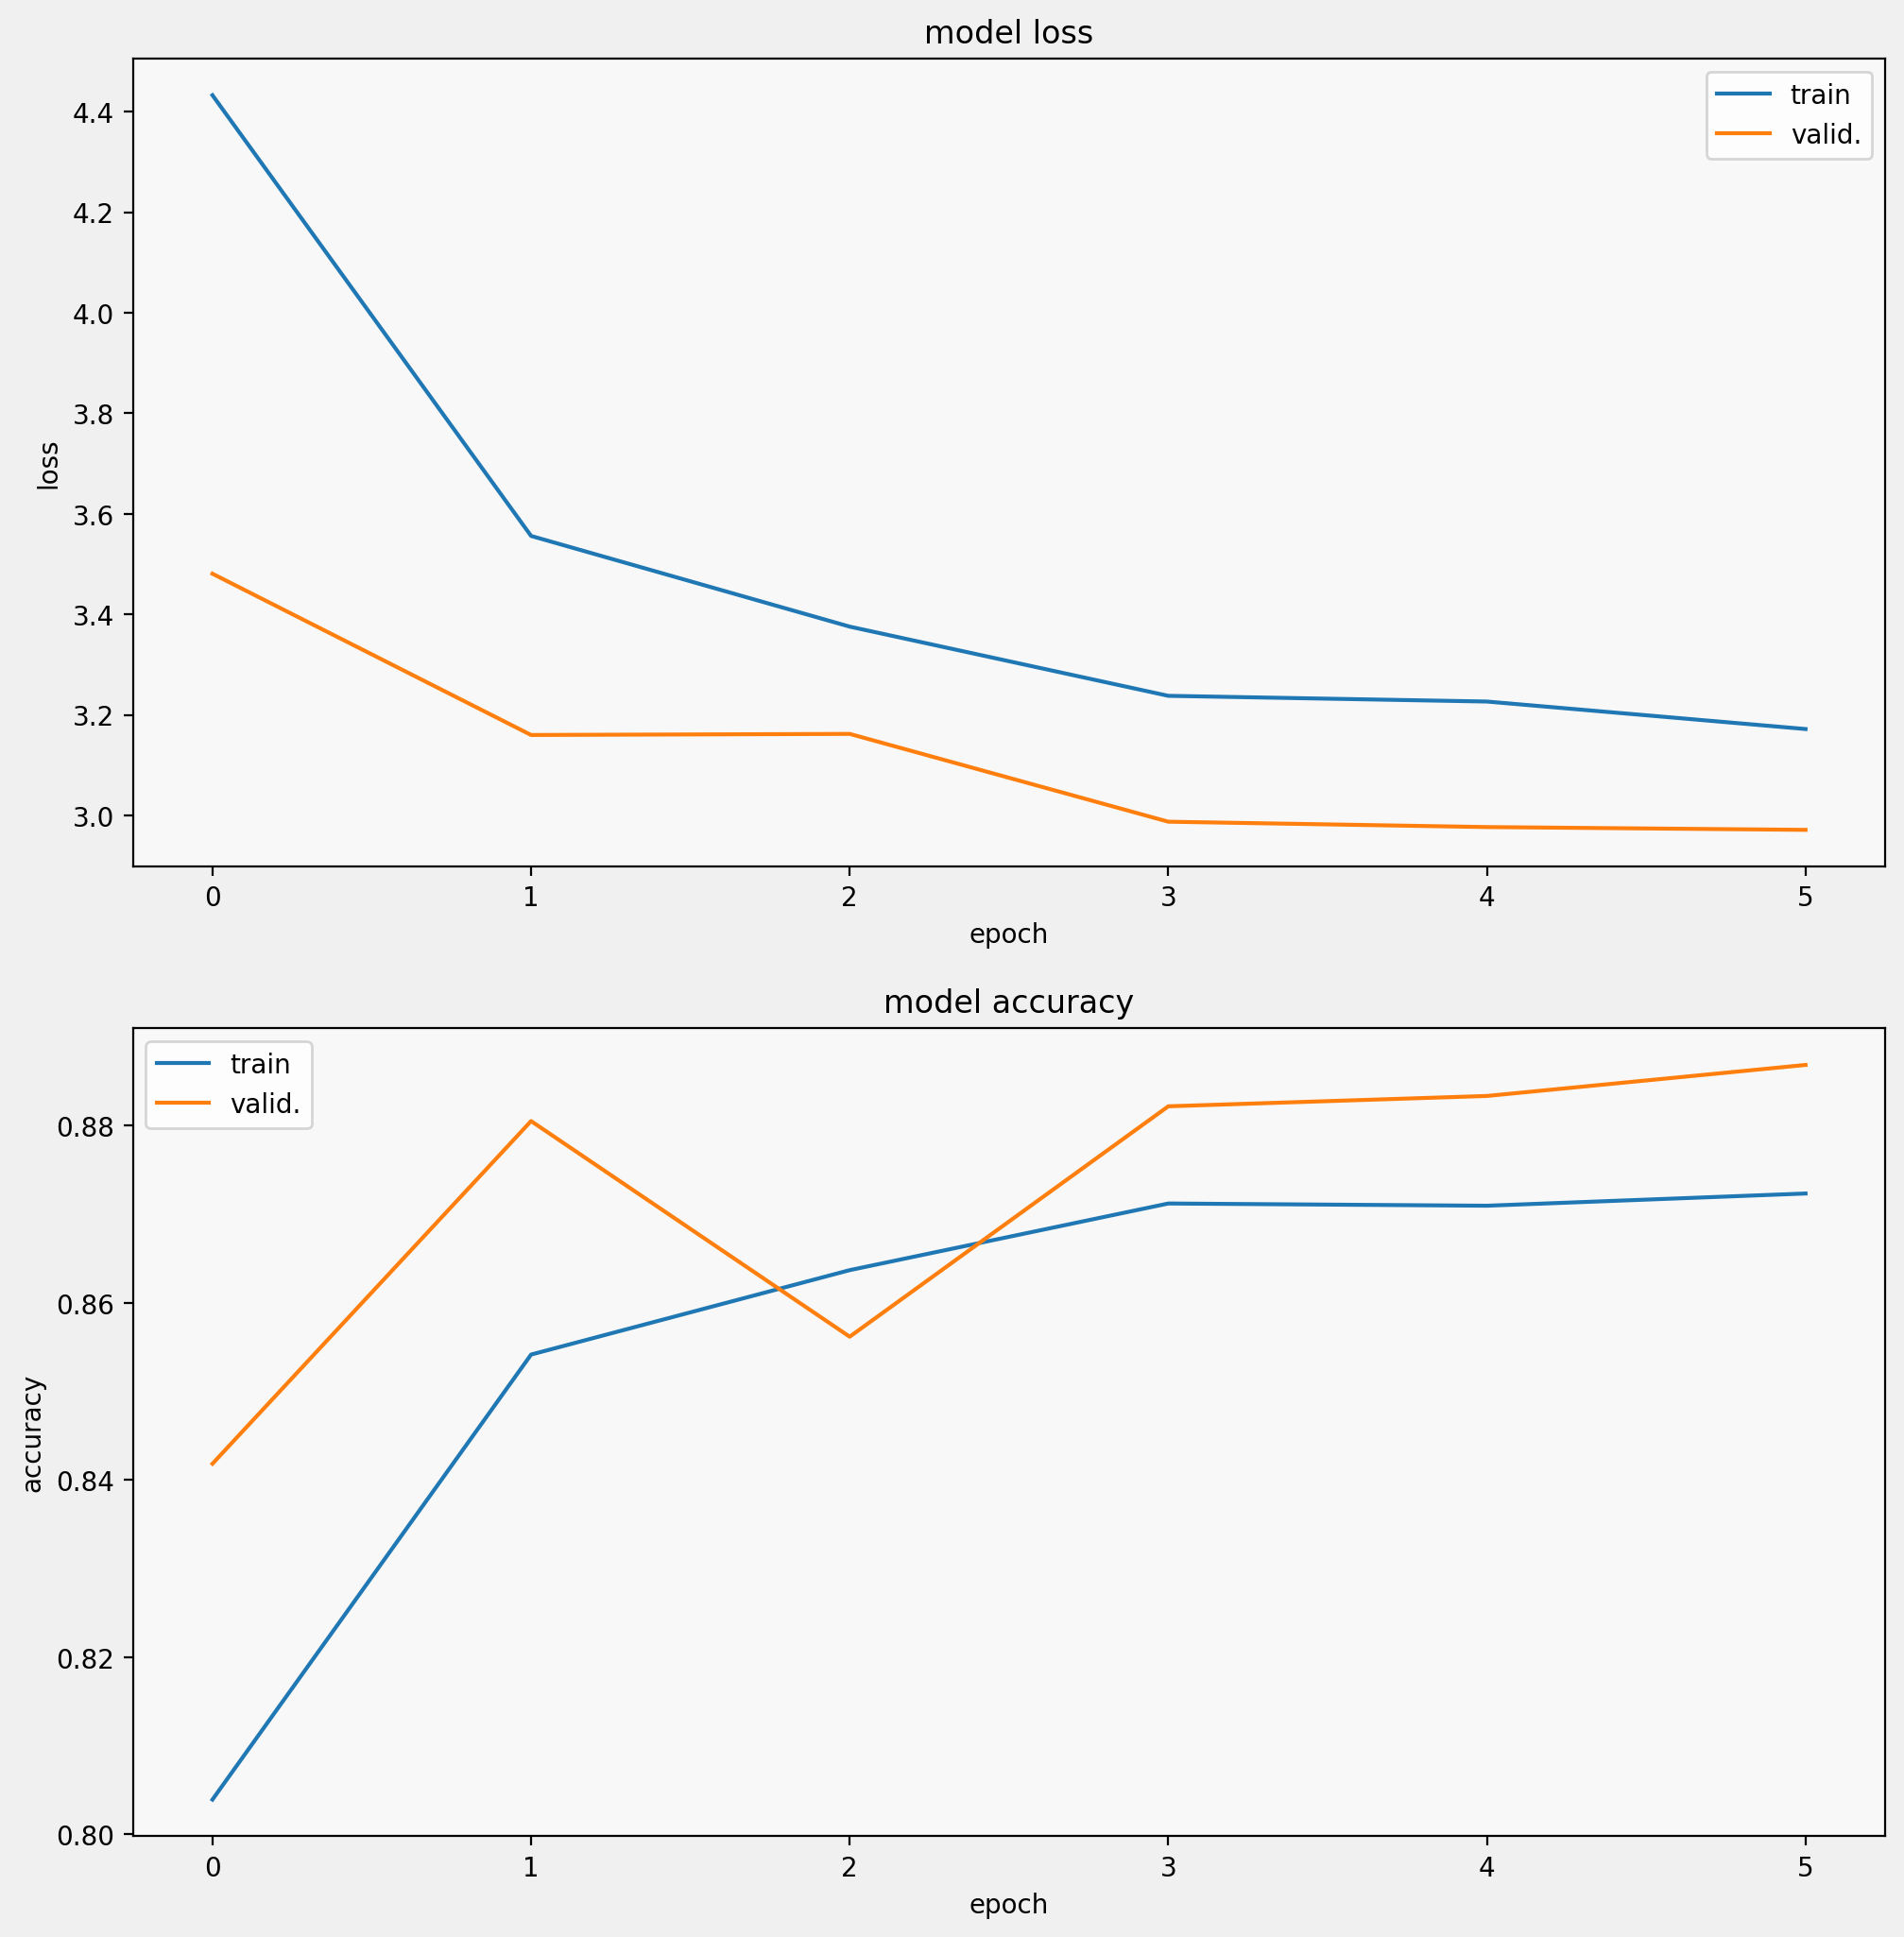

In [47]:
#  Loss vs Validation Loss curve
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)

# Accuracy vs Validation accuracy curve
display_training_curves(
    history.history['binary_accuracy'],
    history.history['val_binary_accuracy'],
    'accuracy',
    212,
)

Not bad! It appears that the validation curve reached around 90% accuracy. Now, let's analyze which class the model had the most difficulty classifying by plotting a confusion matrix.

In [1]:
# Calculate confusion matrix 
cmdataset = get_validation_dataset()
images_ds = cmdataset.map(lambda image, label:image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(val_size))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = (cm_probabilities > 0.5).astype(int)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    y_true=cm_correct_labels,
    y_pred=cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

NameError: name 'get_validation_dataset' is not defined

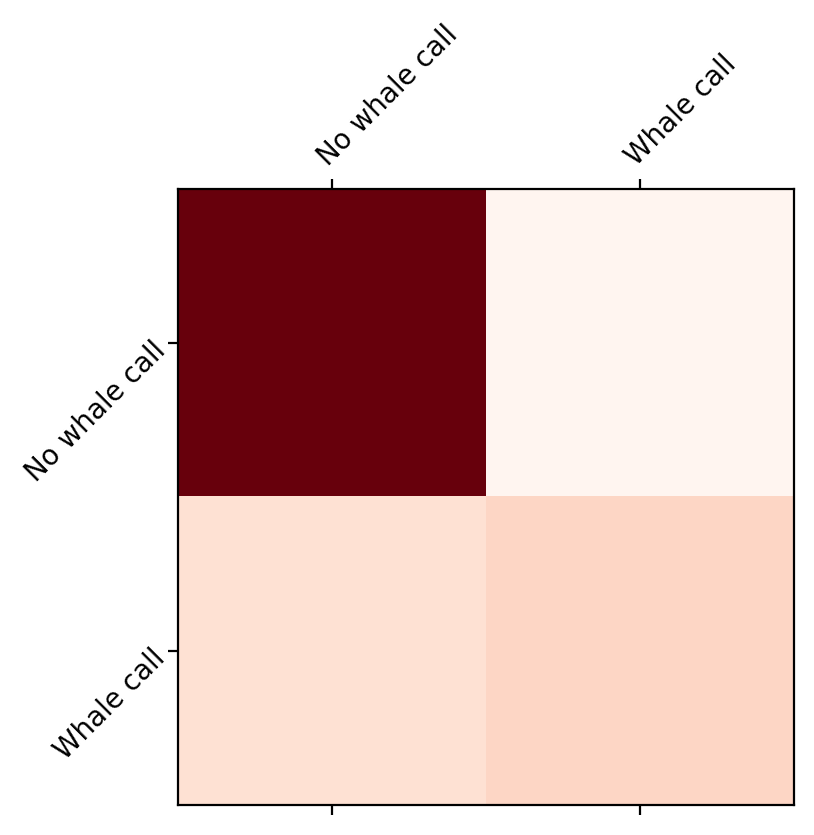

In [59]:
# Display confusion matrix 
display_confusion_matrix(cmat)

"It appears that the model got a little confused and misclassified some No Whale Calls as Whale Calls. However, this did not happen very often.

Now, let's evaluate the overall performance of the model by examining its F1 score, precision, and recall.

In [51]:
#  F1, precision and recall score
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)

print('F1 score of the model is:',round(score,3),'\n')
print('Precision of the model is:',round(precision,3),'\n')
print('Recall of the model is:',round(recall,3),'\n')

F1 score of the model is: 0.816 

Precision of the model is: 0.89 

Recall of the model is: 0.78 



We achieved an impressive F1 score of 0.82 out of 1, which exceeds our expectations. Now, let's perform a visual validation by examining how our model classified some images in the validation set.

In [53]:
# Get 20 images from the validation batch
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

1/1 [==============================] - 0s 476ms/step


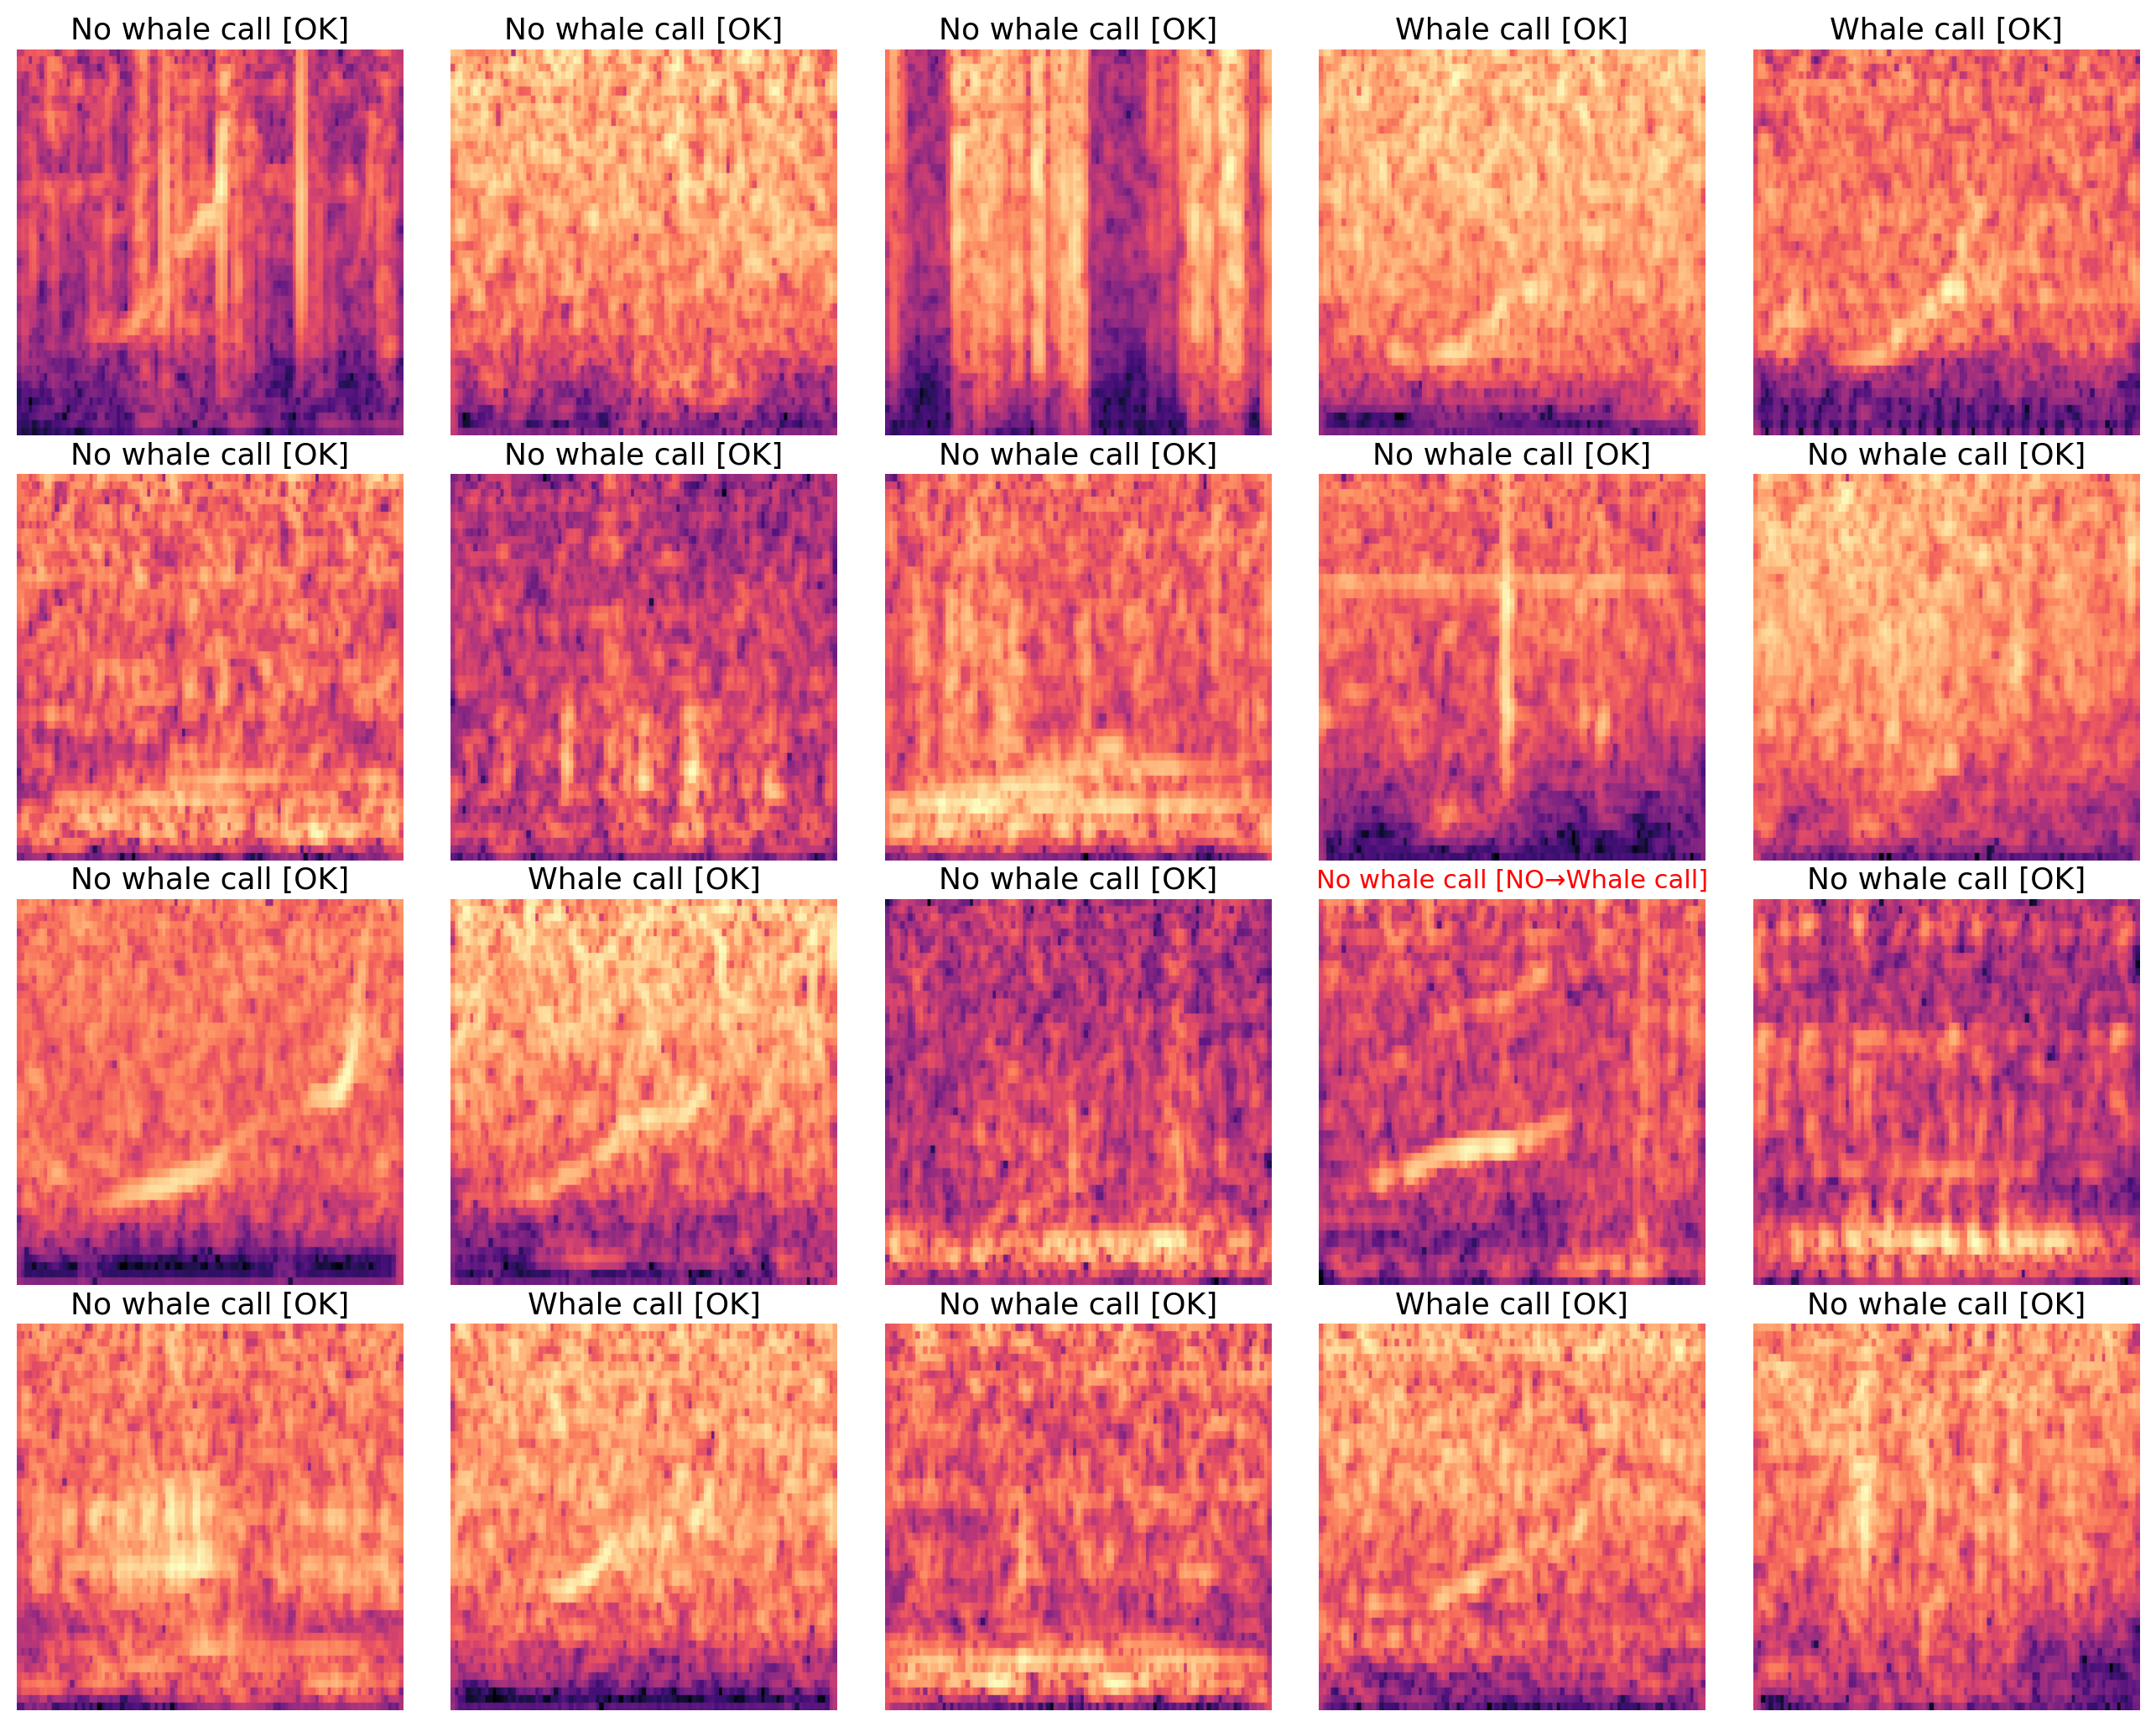

In [55]:
# Perform visual validation
images, labels = next(batch)
probabilities = model.predict(images)
predictions = (probabilities > 0.5).astype(int)
display_batch_of_images((images, labels), predictions)